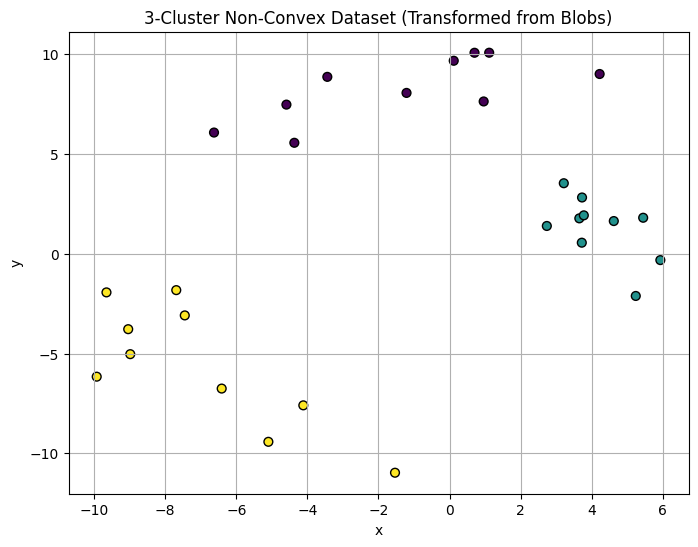

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate 3 non-convex clusters using make_blobs
X, y = make_blobs(n_samples=30, centers=3, random_state=42, cluster_std=1.2)

# Apply a non-linear transformation to make it non-convex
def nonlinear_transform(X):
    # Curve each cluster outward like petals
    X_new = np.zeros_like(X)
    for i in range(len(X)):
        r = np.linalg.norm(X[i])  # radial distance
        theta = np.arctan2(X[i,1], X[i,0]) + 0.5 * np.sin(3 * r)
        X_new[i,0] = r * np.cos(theta)
        X_new[i,1] = r * np.sin(theta)
    return X_new

X_transformed = nonlinear_transform(X)

# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='viridis', s=40, edgecolors='k')
plt.title("3-Cluster Non-Convex Dataset (Transformed from Blobs)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

开始训练...
Epoch 1/250 - Loss: -0.1601
Epoch 11/250 - Loss: -0.2114
Epoch 21/250 - Loss: -0.2415
Epoch 31/250 - Loss: -0.2658
Epoch 41/250 - Loss: -0.2853
Epoch 51/250 - Loss: -0.3025
Epoch 61/250 - Loss: -0.3132
Epoch 71/250 - Loss: -0.3204
Epoch 81/250 - Loss: -0.3299
Epoch 91/250 - Loss: -0.3507
Epoch 101/250 - Loss: -0.3614
Epoch 111/250 - Loss: -0.3687
Epoch 121/250 - Loss: -0.3728
Epoch 131/250 - Loss: -0.3748
Epoch 141/250 - Loss: -0.3762
Epoch 151/250 - Loss: -0.3774
Epoch 161/250 - Loss: -0.3797
Epoch 171/250 - Loss: -0.3869
Epoch 181/250 - Loss: -0.3922
Epoch 191/250 - Loss: -0.3936
Epoch 201/250 - Loss: -0.3941
Epoch 211/250 - Loss: -0.3942
Epoch 221/250 - Loss: -0.3943
Epoch 231/250 - Loss: -0.3943
Epoch 241/250 - Loss: -0.3943


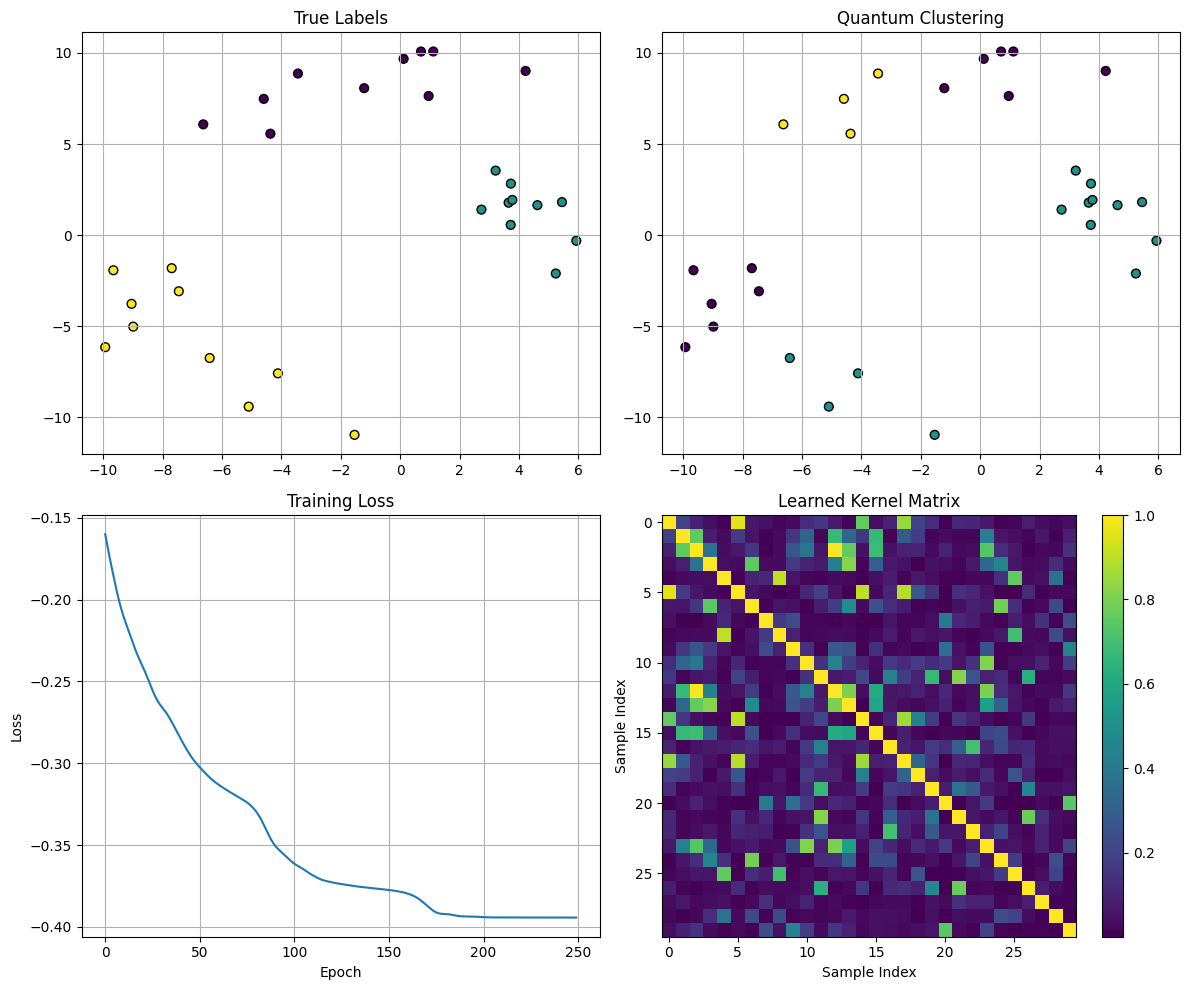

Adjusted Rand Index: 0.3700
Traditional RBF Kernel ARI: 1.0000


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
import pennylane as qml
from pennylane import numpy as np
import pennylane.math as qmlmath

# 生成数据
X, y = make_blobs(n_samples=30, centers=3, random_state=42, cluster_std=1.2)

def nonlinear_transform(X):
    X_new = np.zeros_like(X)
    for i in range(len(X)):
        r = np.linalg.norm(X[i])
        theta = np.arctan2(X[i,1], X[i,0]) + 0.5 * np.sin(3 * r)
        X_new[i,0] = r * np.cos(theta)
        X_new[i,1] = r * np.sin(theta)
    return X_new

X_transformed = nonlinear_transform(X)

# 改进1：使用更温和的缩放
scaler = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2))  # 缩小范围
X_scaled = scaler.fit_transform(X_transformed)

num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

# 改进2：更好的特征映射
def improved_feature_map(x, theta):
    # 数据编码层
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[0] * theta[i], wires=i)
        qml.RY(x[1] * theta[i + num_qubits], wires=i)
    
    # 纠缠层 - 增加表达能力
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i + 1) % num_qubits])
    
    # 再次编码层
    for i in range(num_qubits):
        qml.RZ(x[0] * theta[i + 2*num_qubits], wires=i)
        qml.RY(x[1] * theta[i + 3*num_qubits], wires=i)

@qml.qnode(dev, interface='autograd')
def quantum_kernel(x1, x2, theta):
    improved_feature_map(x1, theta)
    qml.adjoint(improved_feature_map)(x2, theta)
    return qml.probs(wires=range(num_qubits))

# 改进3：修正的核函数 - 使用保真度而不是单一概率
@qml.qnode(dev, interface='autograd')
def quantum_fidelity(x1, x2, theta):
    # 制备第一个态
    improved_feature_map(x1, theta)
    # 测量与第二个态的重叠
    qml.adjoint(improved_feature_map)(x2, theta)
    # 返回所有概率的第一个分量作为保真度度量
    return qml.expval(qml.PauliZ(0))  # 使用期望值而不是概率

def kernel_matrix(X, theta):
    n = len(X)
    K = qmlmath.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1):
            if i == j:
                # 对角线元素设为1（完美相似）
                k_val = 1.0
            else:
                # 非对角线元素使用量子核函数
                probs = quantum_kernel(X[i], X[j], theta)
                k_val = probs[0]  # 使用第一个概率分量
            
            K = qmlmath.scatter_element_add(K, (i, j), k_val)
            if i != j:
                K = qmlmath.scatter_element_add(K, (j, i), k_val)
    
    return K

# 改进4：更好的损失函数设计
def improved_loss(theta, X):
    K = kernel_matrix(X, theta)
    n = len(X)
    
    # 计算类内和类间的平均相似度
    # 由于我们不知道真实标签，使用距离作为proxy
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distances[i, j] = np.linalg.norm(X[i] - X[j])
    
    # 找到每个点的k近邻作为"应该相似"的点
    k_neighbors = 3
    neighbor_similarities = []
    non_neighbor_similarities = []
    
    for i in range(n):
        # 找到k个最近邻居
        neighbor_indices = np.argsort(distances[i])[1:k_neighbors+1]  # 排除自己
        
        # 收集邻居的相似度
        for j in neighbor_indices:
            neighbor_similarities.append(K[i, j])
        
        # 收集非邻居的相似度
        non_neighbor_indices = np.argsort(distances[i])[k_neighbors+1:]
        for j in non_neighbor_indices[:k_neighbors]:  # 取同样数量的非邻居
            non_neighbor_similarities.append(K[i, j])
    
    neighbor_sim = qmlmath.mean(qmlmath.stack(neighbor_similarities))
    non_neighbor_sim = qmlmath.mean(qmlmath.stack(non_neighbor_similarities))
    
    # 损失：希望邻居相似度高，非邻居相似度低
    loss = non_neighbor_sim - neighbor_sim
    return loss

# 改进5：增加参数数量和更好的初始化
np.random.seed(42)
theta = np.random.uniform(0, 2 * np.pi, size=4 * num_qubits, requires_grad=True)

# 使用更小的学习率
opt = qml.AdamOptimizer(stepsize=0.05)
n_epochs = 250
losses = []

print("开始训练...")
for epoch in range(n_epochs):
    theta, loss = opt.step_and_cost(lambda th: improved_loss(th, X_scaled), theta)
    losses.append(float(loss))
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss:.4f}")

# 最终聚类
K_final = kernel_matrix(X_scaled, theta)
K_np = np.array(K_final)

# 确保核矩阵是正定的
K_np = (K_np + K_np.T) / 2  # 确保对称
eigenvals = np.linalg.eigvals(K_np)
if np.min(eigenvals) < 0:
    K_np = K_np + (1e-6 - np.min(eigenvals)) * np.eye(len(K_np))

sc = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=42)
predicted_labels = sc.fit_predict(K_np)

# 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 原始数据
axes[0,0].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='viridis', s=40, edgecolors='k')
axes[0,0].set_title("True Labels")
axes[0,0].grid(True)

# 量子聚类结果
axes[0,1].scatter(X_transformed[:, 0], X_transformed[:, 1], c=predicted_labels, cmap='viridis', s=40, edgecolors='k')
axes[0,1].set_title("Quantum Clustering")
axes[0,1].grid(True)

# 训练损失
axes[1,0].plot(losses)
axes[1,0].set_title("Training Loss")
axes[1,0].set_xlabel("Epoch")
axes[1,0].set_ylabel("Loss")
axes[1,0].grid(True)

# 核矩阵可视化
im = axes[1,1].imshow(K_np, cmap='viridis', aspect='auto')
axes[1,1].set_title("Learned Kernel Matrix")
axes[1,1].set_xlabel("Sample Index")
axes[1,1].set_ylabel("Sample Index")
plt.colorbar(im, ax=axes[1,1])

plt.tight_layout()
plt.show()

# 计算聚类准确率
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y, predicted_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

# 比较传统谱聚类
from sklearn.metrics.pairwise import rbf_kernel
K_rbf = rbf_kernel(X_scaled, gamma=1.0)
sc_traditional = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=42)
traditional_labels = sc_traditional.fit_predict(K_rbf)
ari_traditional = adjusted_rand_score(y, traditional_labels)
print(f"Traditional RBF Kernel ARI: {ari_traditional:.4f}")

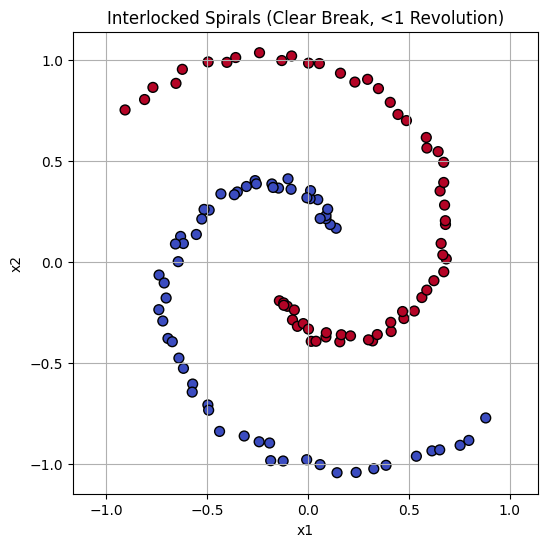

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_interlocked_spirals(n_points_per_arm=30, noise=0.02, revolutions=0.75, radial_gap=0.15):
    X = []
    y = []
    for arm in range(2):
        for i in range(n_points_per_arm):
            r = i / n_points_per_arm + radial_gap  # 保证开始不从原点，避免连接
            theta = revolutions * 2 * np.pi * r
            if arm == 1:
                theta += np.pi  # 第二个螺旋旋转180度
            x = r * np.cos(theta) + np.random.normal(0, noise)
            y_ = r * np.sin(theta) + np.random.normal(0, noise)
            X.append([x, y_])
            y.append(arm)
    return np.array(X), np.array(y)

# 生成数据
X, y = generate_interlocked_spirals(n_points_per_arm=60, noise=0.02, revolutions=0.75, radial_gap=0.2)

# 可视化
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50, edgecolor='k')
plt.title("Interlocked Spirals (Clear Break, <1 Revolution)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis('equal')
plt.grid(True)
plt.show()


开始训练...
Epoch 1/100 - Loss: -0.3089
Epoch 11/100 - Loss: -0.3378
Epoch 21/100 - Loss: -0.3514
Epoch 31/100 - Loss: -0.3602
Epoch 41/100 - Loss: -0.3641
Epoch 51/100 - Loss: -0.3662
Epoch 61/100 - Loss: -0.3682
Epoch 71/100 - Loss: -0.3710
Epoch 81/100 - Loss: -0.3795
Epoch 91/100 - Loss: -0.3896


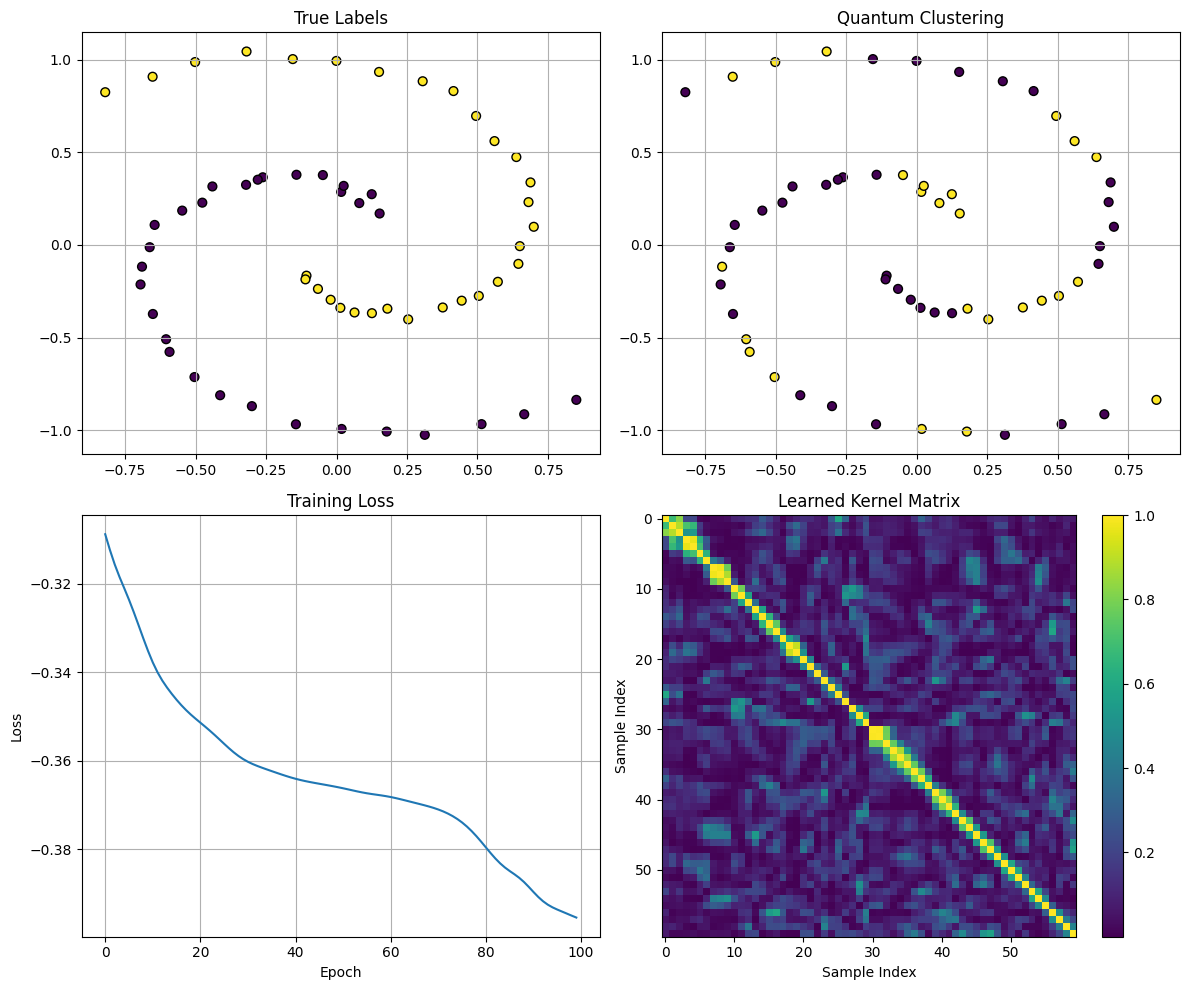

Adjusted Rand Index: -0.0156
Traditional RBF Kernel ARI: 0.1195


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
import pennylane as qml
from pennylane import numpy as np
import pennylane.math as qmlmath


# 改进1：使用更温和的缩放
scaler = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2))  # 缩小范围
X_scaled = scaler.fit_transform(X)

num_qubits = 3
dev = qml.device("default.qubit", wires=num_qubits)

# 改进2：更好的特征映射
def improved_feature_map(x, theta):
    # 数据编码层
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[0] * theta[i], wires=i)
        qml.RY(x[1] * theta[i + num_qubits], wires=i)
    
    # 纠缠层 - 增加表达能力
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i + 1) % num_qubits])
    
    # 再次编码层
    for i in range(num_qubits):
        qml.RZ(x[0] * theta[i + 2*num_qubits], wires=i)
        qml.RY(x[1] * theta[i + 3*num_qubits], wires=i)

@qml.qnode(dev, interface='autograd')
def quantum_kernel(x1, x2, theta):
    improved_feature_map(x1, theta)
    qml.adjoint(improved_feature_map)(x2, theta)
    return qml.probs(wires=range(num_qubits))

# 改进3：修正的核函数 - 使用保真度而不是单一概率
@qml.qnode(dev, interface='autograd')
def quantum_fidelity(x1, x2, theta):
    # 制备第一个态
    improved_feature_map(x1, theta)
    # 测量与第二个态的重叠
    qml.adjoint(improved_feature_map)(x2, theta)
    # 返回所有概率的第一个分量作为保真度度量
    return qml.expval(qml.PauliZ(0))  # 使用期望值而不是概率

def kernel_matrix(X, theta):
    n = len(X)
    K = qmlmath.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1):
            if i == j:
                # 对角线元素设为1（完美相似）
                k_val = 1.0
            else:
                # 非对角线元素使用量子核函数
                probs = quantum_kernel(X[i], X[j], theta)
                k_val = probs[0]  # 使用第一个概率分量
            
            K = qmlmath.scatter_element_add(K, (i, j), k_val)
            if i != j:
                K = qmlmath.scatter_element_add(K, (j, i), k_val)
    
    return K

# 改进4：更好的损失函数设计
def improved_loss(theta, X):
    K = kernel_matrix(X, theta)
    n = len(X)
    
    # 计算类内和类间的平均相似度
    # 由于我们不知道真实标签，使用距离作为proxy
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distances[i, j] = np.linalg.norm(X[i] - X[j])
    
    # 找到每个点的k近邻作为"应该相似"的点
    k_neighbors = 10
    neighbor_similarities = []
    non_neighbor_similarities = []
    
    for i in range(n):
        # 找到k个最近邻居
        neighbor_indices = np.argsort(distances[i])[1:k_neighbors+1]  # 排除自己
        
        # 收集邻居的相似度
        for j in neighbor_indices:
            neighbor_similarities.append(K[i, j])
        
        # 收集非邻居的相似度
        non_neighbor_indices = np.argsort(distances[i])[k_neighbors+1:]
        for j in non_neighbor_indices[:k_neighbors]:  # 取同样数量的非邻居
            non_neighbor_similarities.append(K[i, j])
    
    neighbor_sim = qmlmath.mean(qmlmath.stack(neighbor_similarities))
    non_neighbor_sim = qmlmath.mean(qmlmath.stack(non_neighbor_similarities))
    
    # 损失：希望邻居相似度高，非邻居相似度低
    loss = non_neighbor_sim - neighbor_sim
    return loss

# 改进5：增加参数数量和更好的初始化
np.random.seed(42)
theta = np.random.uniform(0, 2 * np.pi, size=4 * num_qubits, requires_grad=True)

# 使用更小的学习率
opt = qml.AdamOptimizer(stepsize=0.05)
n_epochs = 100
losses = []

print("开始训练...")
for epoch in range(n_epochs):
    theta, loss = opt.step_and_cost(lambda th: improved_loss(th, X_scaled), theta)
    losses.append(float(loss))
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss:.4f}")

# 最终聚类
K_final = kernel_matrix(X_scaled, theta)
K_np = np.array(K_final)

# 确保核矩阵是正定的
K_np = (K_np + K_np.T) / 2  # 确保对称
eigenvals = np.linalg.eigvals(K_np)
if np.min(eigenvals) < 0:
    K_np = K_np + (1e-6 - np.min(eigenvals)) * np.eye(len(K_np))

sc = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=42)
predicted_labels = sc.fit_predict(K_np)

# 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 原始数据
axes[0,0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=40, edgecolors='k')
axes[0,0].set_title("True Labels")
axes[0,0].grid(True)

# 量子聚类结果
axes[0,1].scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', s=40, edgecolors='k')
axes[0,1].set_title("Quantum Clustering")
axes[0,1].grid(True)

# 训练损失
axes[1,0].plot(losses)
axes[1,0].set_title("Training Loss")
axes[1,0].set_xlabel("Epoch")
axes[1,0].set_ylabel("Loss")
axes[1,0].grid(True)

# 核矩阵可视化
im = axes[1,1].imshow(K_np, cmap='viridis', aspect='auto')
axes[1,1].set_title("Learned Kernel Matrix")
axes[1,1].set_xlabel("Sample Index")
axes[1,1].set_ylabel("Sample Index")
plt.colorbar(im, ax=axes[1,1])

plt.tight_layout()
plt.show()

# 计算聚类准确率
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y, predicted_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

# 比较传统谱聚类
from sklearn.metrics.pairwise import rbf_kernel
K_rbf = rbf_kernel(X_scaled, gamma=1.0)
sc_traditional = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=42)
traditional_labels = sc_traditional.fit_predict(K_rbf)
ari_traditional = adjusted_rand_score(y, traditional_labels)
print(f"Traditional RBF Kernel ARI: {ari_traditional:.4f}")

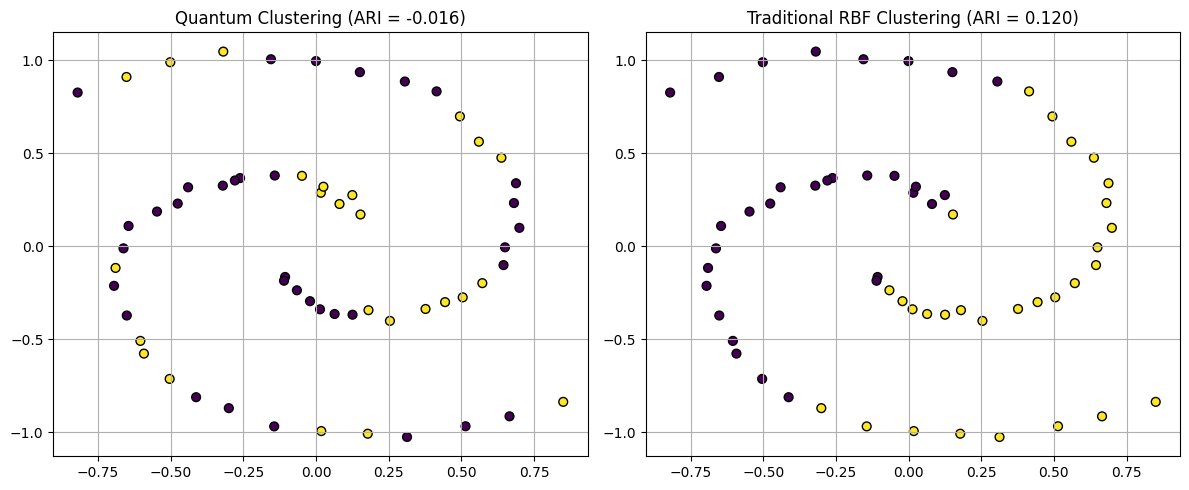

In [21]:
# Create comparison plot
plt.figure(figsize=(12, 5))

# Quantum clustering result
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', s=40, edgecolors='k')
plt.title(f"Quantum Clustering (ARI = {ari:.3f})")
plt.grid(True)

# Traditional spectral clustering result
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=traditional_labels, cmap='viridis', s=40, edgecolors='k')
plt.title(f"Traditional RBF Clustering (ARI = {ari_traditional:.3f})")
plt.grid(True)

plt.tight_layout()
plt.show()

# Quantum-Enhanced Graph Neural Network for Geometric Data Clustering

This notebook demonstrates an end-to-end quantum-classical hybrid approach for clustering data with complex geometric structures (e.g., interlocked spirals). The method combines graph theory with quantum circuit learning through five key stages:

## 🌐 1. Data Generation & Graph Construction

```python
X, y = generate_interlocked_spirals()
adj = build_adaptive_graph(X)
```

**Input**: 2D points with spiral patterns

**Graph Building Rules**:
- Connect points within `distance_threshold` (e.g., 0.25)
- Only link points with similar angular relationships

**Output**: Weighted adjacency matrix where edge weights decay exponentially with distance

## ⚛️ 2. Quantum Feature Extraction

```python
path_dists = shortest_path(adj)
quantum_feats = quantum_path_integral_features(adj, path_dists)
```

**Quantum Circuit Operations**:
1. **Node Encoding**: `RY(node_index * π/N)`
2. **Path Encoding**: `RY(exp(-distance/5)*π)`
3. **Entanglement**: Sequential CNOT gates
4. **Measurement**: `PauliZ` expectation values

**Example Transformation**:
```
Node 0 (classical) → [0.8, 0.2] 
↓ Quantum Circuit ↓  
Node 0 (quantum)  → [0.92, -0.35, 0.68, 0.15]
```

## 🧠 3. Quantum Classifier Training

```python
clf = GlobalQuantumClassifier(n_qubits=4)
loss_history = clf.train(quantum_feats, path_dists, y)
```

**Training Mechanism**:

**Circuit Architecture**:
```
RY Feature Encoding → Variational Layers → Ring-Entanglement → PauliZ Measurement
```

**Loss Components**:
- **Classification Loss**: `(output - (2*y-1))²`
- **Graph Regularization**: `∑ exp(-dᵢⱼ)*(outputᵢ - outputⱼ)²`

**Parameter Update**: Adam optimizer with automatic gradient calculation

## 🔄 4. Post-Processing

```python
final_preds = connected_component_consistency(adj, raw_preds)
```

**Consistency Enforcement**:
1. Detect connected components in graph
2. For each component:
   - If >90% nodes agree on label → enforce majority vote
   - Else keep original predictions

## 📊 5. Evaluation

**Metrics**:
```python
ari = adjusted_rand_score(y, final_preds)
```

- **Quantum vs Classical**: Compare ARI scores with RBF-kernel spectral clustering
- **Visualization**: Side-by-side plots showing quantum separation capability

## Key Innovations

- **Geometric-Aware Graph**: Angular constraints prevent incorrect connections
- **Path-Integrated Quantum Features**: Encodes both local and global topology
- **Graph-Guided Training**: Loss function respects node connectivity

Epoch 0: Loss = 1.7433
Epoch 10: Loss = 0.8484
Epoch 20: Loss = 0.7213
Epoch 30: Loss = 0.6631
Epoch 40: Loss = 0.6076
Epoch 50: Loss = 0.5769
Epoch 60: Loss = 0.5647
Epoch 70: Loss = 0.5534
Epoch 80: Loss = 0.5384
Epoch 90: Loss = 0.5293
Epoch 100: Loss = 0.5284
Epoch 110: Loss = 0.5242
Epoch 120: Loss = 0.5187
Epoch 130: Loss = 0.5133
Epoch 140: Loss = 0.5106
Epoch 150: Loss = 0.5103
Epoch 160: Loss = 0.5103
Epoch 170: Loss = 0.5102
Epoch 180: Loss = 0.5102
Epoch 190: Loss = 0.5102


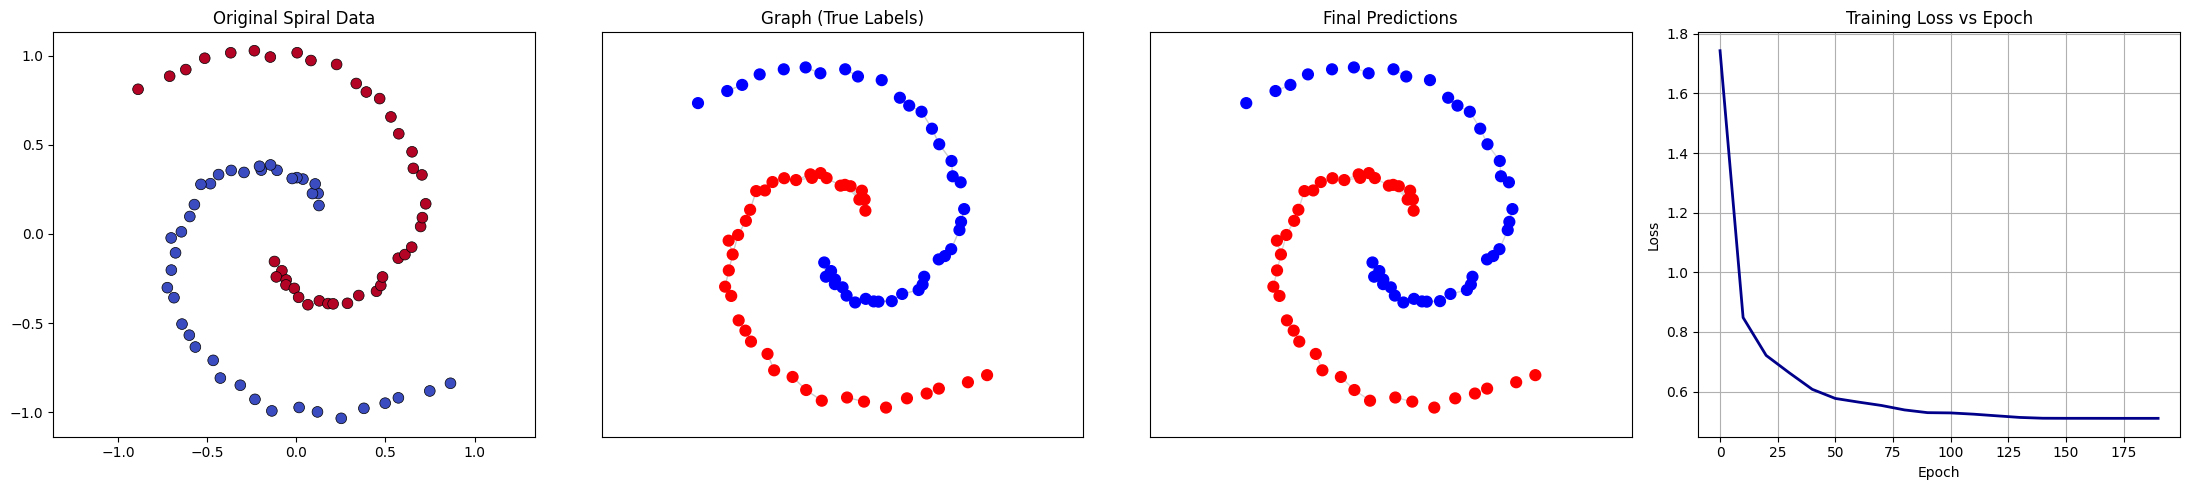


Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components, shortest_path
import pennylane as qml
from pennylane import numpy as pnp
import warnings
warnings.filterwarnings('ignore')

# --- Data Generation ---
def generate_interlocked_spirals(n_points_per_arm=30, noise=0.02, revolutions=0.75, radial_gap=0.15):
    X, y = [], []
    for arm in range(2):
        for i in range(n_points_per_arm):
            r = i / n_points_per_arm + radial_gap
            theta = revolutions * 2 * np.pi * r
            if arm == 1:
                theta += np.pi
            x = r * np.cos(theta) + np.random.normal(0, noise)
            y_ = r * np.sin(theta) + np.random.normal(0, noise)
            X.append([x, y_])
            y.append(arm)
    return np.array(X), np.array(y)

# --- Adaptive Graph Construction ---
def build_adaptive_graph(X, distance_threshold=0.3):
    n = len(X)
    adj = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(X[i] - X[j])
            if dist < distance_threshold:
                # Calculate angle difference between 2 points
                a1 = np.arctan2(X[i][1], X[i][0])
                a2 = np.arctan2(X[j][1], X[j][0])
                diff = abs(a1 - a2)
                diff = min(diff, 2*np.pi - diff)
                if diff < np.pi / 3:
                    # Only if the angle difference is small, apply Gaussian weight for the adjacency
                    w = np.exp(-dist**2 / (2 * 0.1**2))
                    adj[i, j] = w
                    adj[j, i] = w
    return adj

# --- Quantum Feature Extraction ---
def quantum_path_integral_features(adjacency, path_distances, n_qubits=4):
    n_nodes = len(adjacency)
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def circuit(node_idx, dists, adj_row):
        # Encode the node index to the first qubit
        qml.RY(node_idx * np.pi / n_nodes, wires=0)
        for i in range(min(len(dists), n_qubits)):
            # Encode （top n-qubits）closest distances to qubits
            if dists[i] < np.inf:
                qml.RY(np.exp(-dists[i]/5) * np.pi, wires=i)
        for i in range(n_qubits - 1):
            # Entangle adjacent qubits 
            qml.CNOT(wires=[i, i + 1])
        for i in range(min(len(adj_row), n_qubits)):
            # Encode (top n_qubits) closest adjacency information
            if adj_row[i] > 0:
                qml.RZ(adj_row[i] * np.pi, wires=i)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    feats = []
    for i in range(n_nodes):
        try:
            feats.append(circuit(i, path_distances[i], adjacency[i]))
        except:
            feats.append([0]*n_qubits)
    return np.array(feats)

# --- Quantum Classifier ---
class GlobalQuantumClassifier:
    def __init__(self, n_qubits=4, n_layers=2):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.params = pnp.random.random((n_layers, n_qubits * 2), requires_grad=True) * 0.1
        self.dev = qml.device("default.qubit", wires=n_qubits)

    def quantum_circuit(self, x, params):
        @qml.qnode(self.dev, interface='autograd')
        def circuit(features, p):
            for i in range(min(len(features), self.n_qubits)):
                # For each qubit, apply an initial rotation based on the feature
                qml.RY(features[i] * np.pi, wires=i)
            for l in range(self.n_layers):
                for i in range(self.n_qubits):
                    # For each layer, for each qubit, apply a rotation based on the parameters
                    qml.RY(p[l, i], wires=i)
                    qml.RZ(p[l, i + self.n_qubits], wires=i)
                for i in range(self.n_qubits - 1):
                    # Entangle adjacent qubits
                    qml.CNOT(wires=[i, i+1])
                # Entangle the last qubit with the first, forming a cycle
                qml.CNOT(wires=[self.n_qubits-1, 0])
            return qml.expval(qml.PauliZ(0))
        return circuit(x, params)

    def train(self, X, path_dists, y, epochs=100, lr=0.01):
        opt = qml.AdamOptimizer(lr)
        def cost_fn(params):
            loss = 0
            for i in range(len(X)):
                out = self.quantum_circuit(X[i], params)
                target = 2 * y[i] - 1
                l = (out - target)**2
                # Add a regularization term based on path distances
                for j in range(len(X)):
                    if i != j and path_dists[i, j] < 3 and y[i] == y[j]:
                        out_j = self.quantum_circuit(X[j], params)
                        l += 0.3 * np.exp(-path_dists[i, j]) * (out - out_j)**2
                loss += l
            return loss / len(X)

        history = []
        for epoch in range(epochs):
            self.params = opt.step(cost_fn, self.params)
            if epoch % 10 == 0:
                cost = cost_fn(self.params)
                print(f"Epoch {epoch}: Loss = {cost:.4f}")
                history.append(cost)
        return history

    def predict(self, X):
        return np.array([1 if self.quantum_circuit(x, self.params) > 0 else 0 for x in X])

# --- Post-Processing ---
def connected_component_consistency(adjacency, predictions, threshold=0.8):
    n_components, labels = connected_components(csr_matrix(adjacency))
    updated = predictions.copy()
    for comp in range(n_components):
        nodes = np.where(labels == comp)[0]
        if len(nodes) > 3:
            votes = predictions[nodes]
            homo = max(np.mean(votes), 1 - np.mean(votes))
            if homo > threshold:
                majority = 1 if np.sum(votes) > len(votes) / 2 else 0
                updated[nodes] = majority
    return updated

# --- Pipeline ---
np.random.seed(42)
X, y = generate_interlocked_spirals(n_points_per_arm=40, noise=0.02, revolutions=0.75, radial_gap=0.2)
X_norm = (X - X.mean(0)) / X.std(0)
adj = build_adaptive_graph(X_norm, distance_threshold=0.25)
path_dists = shortest_path(csr_matrix(adj), directed=False)
quantum_feats = quantum_path_integral_features(adj, path_dists, n_qubits=4)

clf = GlobalQuantumClassifier(n_qubits=4, n_layers=2)
losses = clf.train(quantum_feats, path_dists, y, epochs=200, lr=0.075)

raw_preds = clf.predict(quantum_feats)
final_preds = connected_component_consistency(adj, raw_preds, threshold=0.9)

# Flip labels if necessary
if np.mean(raw_preds == y) < 0.5:
    raw_preds = 1 - raw_preds
if np.mean(final_preds == y) < 0.5:
    final_preds = 1 - final_preds


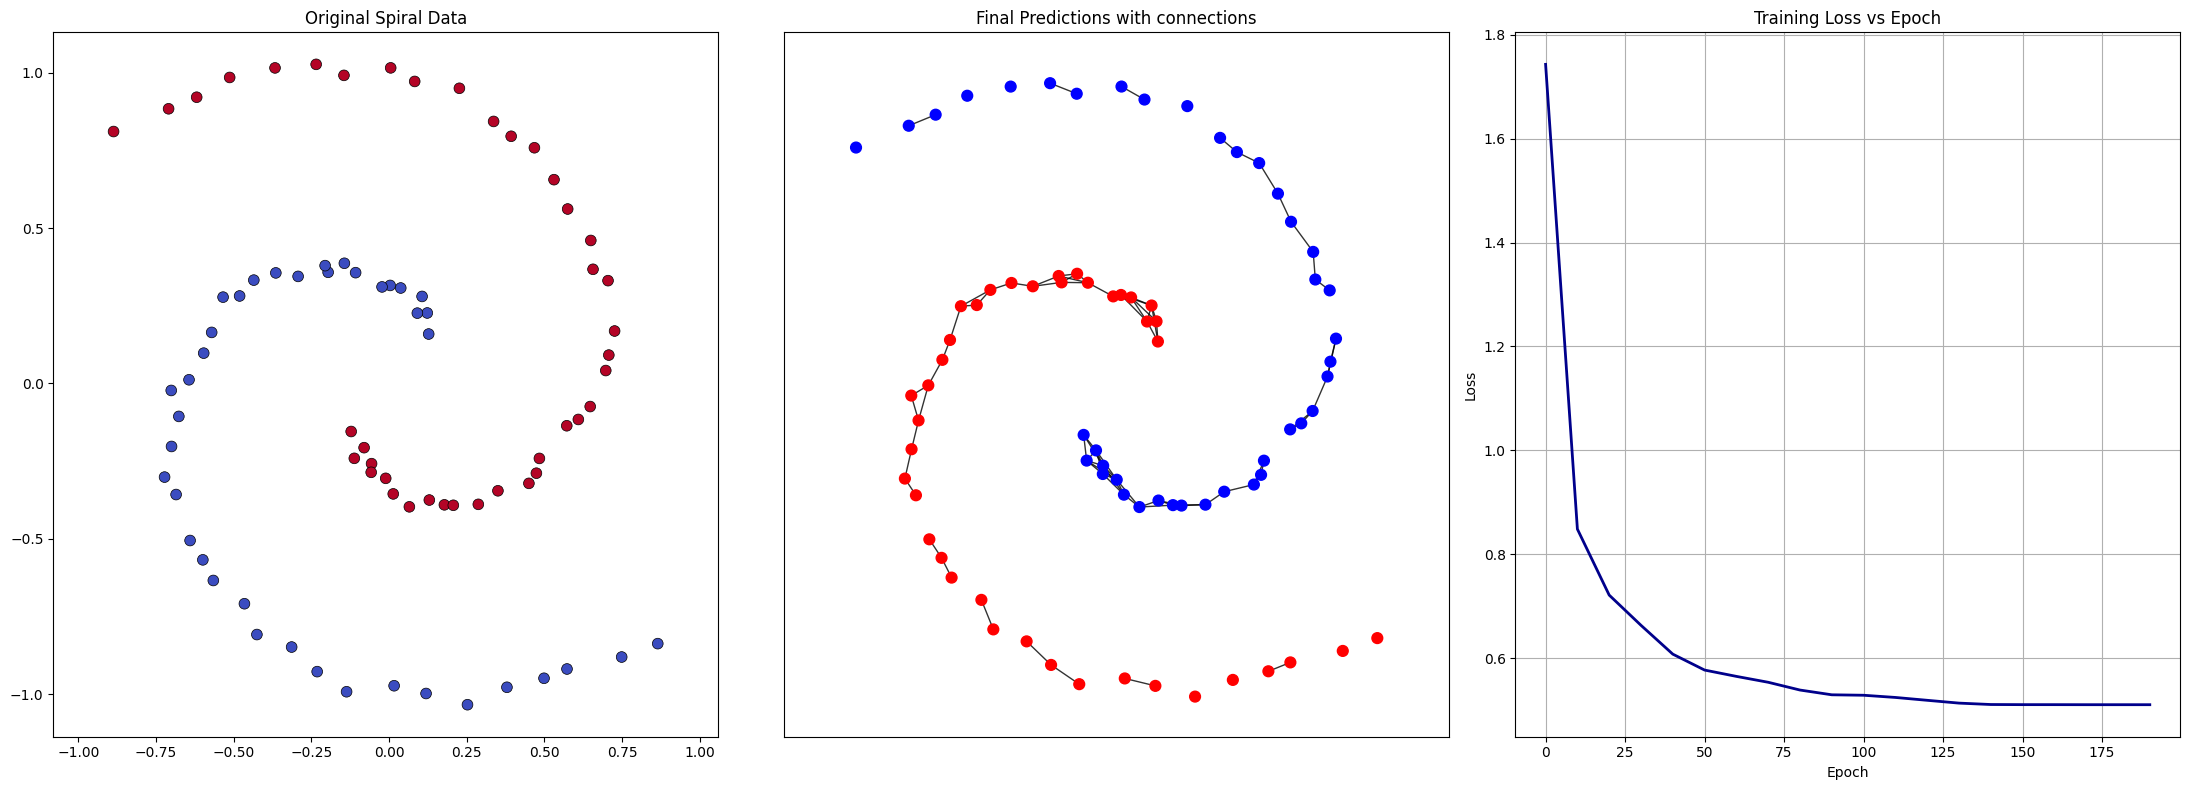


Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [13]:
# --- Plot Results ---
fig, axs = plt.subplots(1, 3, figsize=(22, 8))

# Original data
axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=60, edgecolor='black', linewidth=0.5)
axs[0].set_title("Original Spiral Data")
axs[0].axis('equal')

# Graph structure with true labels
G = nx.from_numpy_array(adj)
pos = {i: X[i] for i in range(len(X))}
# Final predictions with lines
colors = ['red' if label == 0 else 'blue' for label in final_preds]
nx.draw_networkx_edges(G, pos, ax=axs[1], edge_color='black', alpha=0.8)
nx.draw_networkx_nodes(G, pos, ax=axs[1], node_color=colors, node_size=60)
axs[1].set_title("Final Predictions with connections")
axs[1].axis('equal')

# Training loss
axs[2].plot(np.arange(0, len(losses)*10, 10), losses, linewidth=2, color='darkblue')
axs[2].set_title("Training Loss vs Epoch")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss")
axs[2].grid(True)

plt.tight_layout()
plt.show()

# --- Print Metrics ---
print(f"\nAccuracy: {accuracy_score(y, final_preds):.4f}")
print(classification_report(y, final_preds))